In [1]:
# Figure 2 and Figure S4

In [2]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import stats
import xarray as xr

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Original simulations (same function as in Fig1)
variable = "SpeciesConc_O3"
ref = tools.get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
refshort = tools.get_original_values_diff(variable, "all_refshort_c48", "all_refSNOxshort_c48", conversion_factor=1e9, resolution='c48')
polshort = tools.get_original_values_diff(variable, "all_polshort_c48", "all_polSNOxshort_c48", conversion_factor=1e9, resolution='c48')

In [4]:
# Part 1: Regional-mean O3 response - distributions
comparison_months = [4,5,6,7,8]
calculate_mean = lambda da: da.sel(time=da.time.dt.month.isin(comparison_months)).resample(time='1Y').mean()
ref_mean = calculate_mean(ref)
refshort_mean = calculate_mean(refshort)
polshort_mean = calculate_mean(polshort)

In [5]:
# Part 2: Percent of O3 disbenefit days - distributions

# Original simulations
variable = "SpeciesConc_O3"
ref_ratio = tools.get_original_values_ratio(variable, "all_ref_c48", "all_refSNOx_c48", resolution='c48')
refshort_ratio = tools.get_original_values_ratio(variable, "all_refshort_c48", "all_refSNOxshort_c48", resolution='c48')
polshort_ratio = tools.get_original_values_ratio(variable, "all_polshort_c48", "all_polSNOxshort_c48",resolution='c48')


In [6]:
def get_regional_days_per_season(region_num, months, present_ratio, future_ratio):
    """Calculate the regionally-averaged number of O3 disbenefit days per season (n=80)."""

    def process_ratio(ratio, region_num, months):
        """Selects months, crops to region, removes 'region' dim, and compute total disbenefit days."""
        ratio = ratio.sel(time=ratio.time.dt.month.isin(months)) # select months 
        ratio = tools.crop_regionmask_ar6_c48(ratio, region_num) # crop region
        
        if "region" in ratio.dims:
            ratio = ratio.isel(region=0)

        total_days = ratio.resample(time='1Y').count(dim='time') # count total # of days per season (153 days)
        mean_total_days = total_days.mean(dim=['Ydim', 'Xdim', 'nf']) # calculate regional-mean total # of days

        disbn_days = ratio.where(ratio > 1).resample(time='1Y').count(dim='time') # count disbenefit days per season
        mean_disbn_days = disbn_days.mean(dim=['Ydim', 'Xdim', 'nf']) # calculate regional-mean # of disbenefit days
        
        return mean_total_days, mean_disbn_days

    # Process present and future data
    mean_total_present_days, mean_present_disbn_days = process_ratio(present_ratio, region_num, months) # present
    mean_total_future_days, mean_future_disbn_days = process_ratio(future_ratio, region_num, months) # future

    # Compute percentage of disbenefit days
    present_disbn_days_percent = (mean_present_disbn_days / mean_total_present_days).values.flatten()*100
    future_disbn_days_percent = (mean_future_disbn_days / mean_total_future_days).values.flatten()*100

    return present_disbn_days_percent, future_disbn_days_percent


In [7]:
# Part 2: O3 disbenefit days per season

# Historical ("Present") and High-Warming ("Future")

region_num = 5 # ENA
ENA_present, ENA_future = get_regional_days_per_season(region_num, comparison_months, ref_ratio, refshort_ratio)

region_num = 17 # WCE
WCE_present, WCE_future = get_regional_days_per_season(region_num, comparison_months, ref_ratio, refshort_ratio)

region_num = 58 # NEA (previously "EAS")
EAS_present, EAS_future = get_regional_days_per_season(region_num, comparison_months, ref_ratio, refshort_ratio)

# Low-Warming ("Future")

region_num = 5
_, ENA_futurepol = get_regional_days_per_season(region_num, comparison_months, ref_ratio, polshort_ratio)

region_num = 17
_, WCE_futurepol = get_regional_days_per_season(region_num, comparison_months, ref_ratio, polshort_ratio)

region_num = 58
_, EAS_futurepol = get_regional_days_per_season(region_num, comparison_months, ref_ratio, polshort_ratio)


In [8]:
def plot_histogram(ax, data1, data2, num_bins, title, color2):
    """
    Helper function to plot histograms and calculate KS-test p-value.
    """

    # Histogram
    min_val = min(np.concatenate([data1]).min(), np.concatenate([data2]).min())
    max_val = max(np.concatenate([data1]).max(), np.concatenate([data2]).max())
    
    sns.histplot(data1, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color='black',
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    sns.histplot(data2, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color=color2,
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    
    # KS-test
    _, pval_ks = stats.ks_2samp(data1, data2)

    def format_pval(pval):
        if pval < 1e-3:
            exponent = int(np.floor(np.log10(pval))) + 1  # conservative rounding
            return f"$p<10^{{{exponent}}}$"
        else:
            return f"$p={pval:.3f}$"

    formatted_pval_ks = format_pval(pval_ks)
    ax.text(.02, 1.25, formatted_pval_ks, ha='left', va='top',
            transform=ax.transAxes, color=color2, fontsize=8)
    
    # Title
    ax.text(-0.1, 1.50, title, ha='left', va='top', transform=ax.transAxes, color='black', fontsize=10)

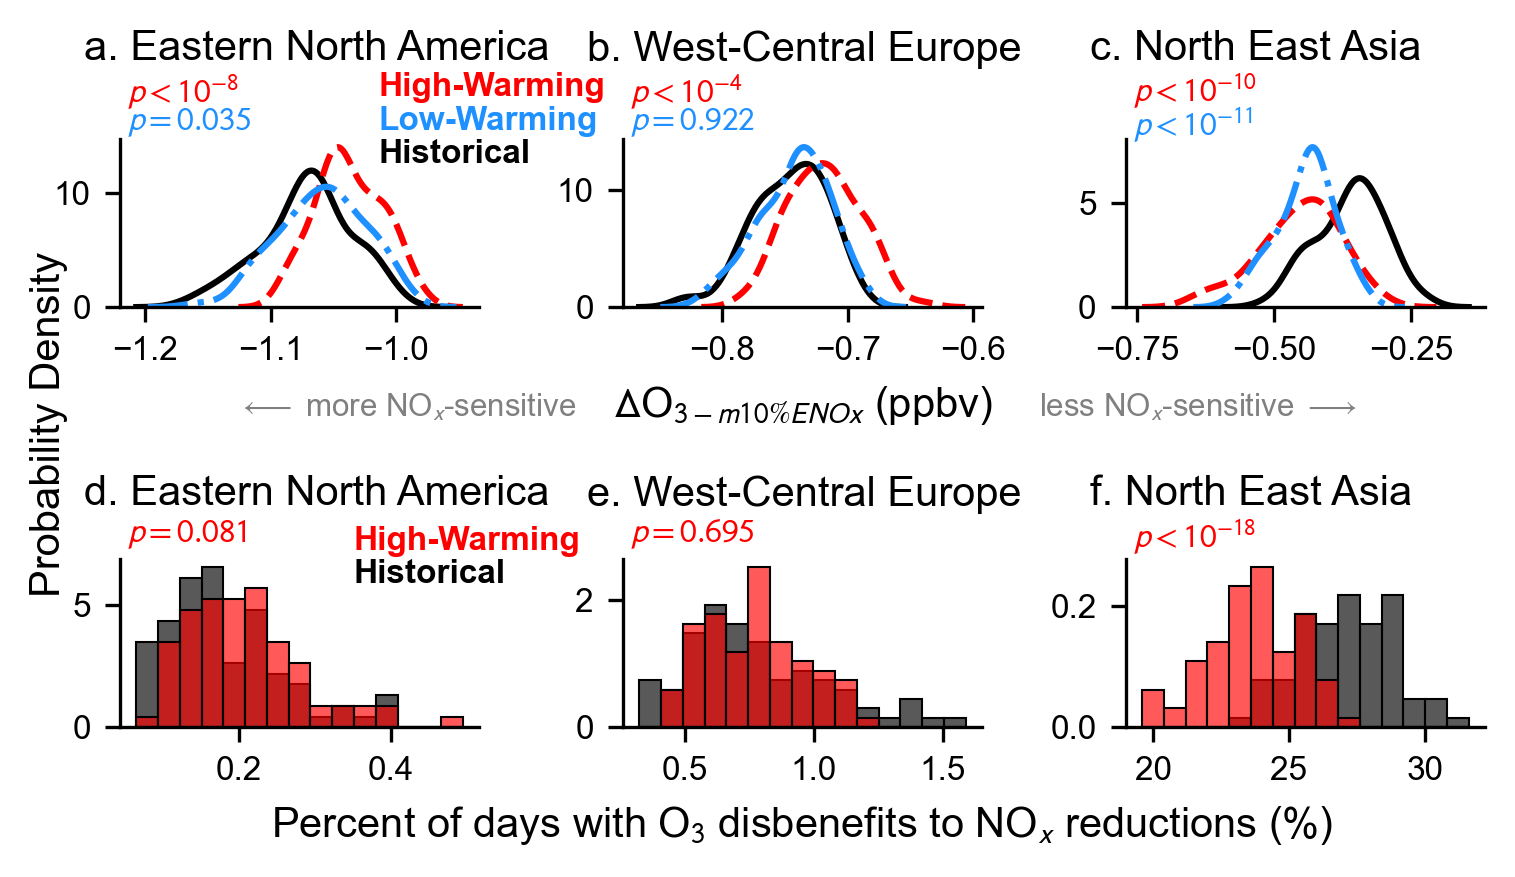

In [9]:
tools.set_matplotlib_font("Arial")

mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 10,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})

fig = plt.figure(figsize=(5.0, 2.8), dpi=300)
gs1 = GridSpec(1, 3, top=0.84, bottom=0.64, left=0.08, right=0.99, hspace=0.50, wspace=0.4)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])
gs2 = GridSpec(1, 3, top=0.34, bottom=0.14, left=0.08, right=0.99, hspace=0.50, wspace=0.4)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[0, 1])
ax6 = fig.add_subplot(gs2[0, 2])

##################################################################
# Part 1: Regional-mean O3 response - distributions
axes = [ax1, ax2, ax3]
titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. North East Asia",
]
ar6_region = {"ENA": 5, "EAS": 58, "WCE": 17}

# Prep storage lists (not used)
all_present_values, all_future_values, all_futurepol_values = [], [], []
all_regions = []

# Loop over regions
for region, idx in zip(["ENA", "WCE", "EAS"], [0,1,2]):
    
    # Crop data once per region
    present_reg = tools.crop_regionmask_ar6_c48(ref_mean, region_num=ar6_region[region])
    future_reg = tools.crop_regionmask_ar6_c48(refshort_mean, region_num=ar6_region[region])  
    futurepol_reg = tools.crop_regionmask_ar6_c48(polshort_mean, region_num=ar6_region[region])    
    
    # Compute spatial average
    present_reg_mean = present_reg.mean(dim=['nf', 'Ydim', 'Xdim'])
    future_reg_mean = future_reg.mean(dim=['nf', 'Ydim', 'Xdim'])
    futurepol_reg_mean = futurepol_reg.mean(dim=['nf', 'Ydim', 'Xdim'])

    # Flatten values
    present_values   = present_reg_mean.values.flatten()
    future_values    = future_reg_mean.values.flatten()
    futurepol_values = futurepol_reg_mean.values.flatten()

    # Append for storage (not used) 
    all_present_values.append(present_values)
    all_future_values.append(future_values)
    all_futurepol_values.append(futurepol_values)
    all_regions.append(region)

    ax = axes[idx]
        
    # KDE plots
    sns.kdeplot(data=present_values, ax=ax, color='black', linestyle='-', fill=False, legend='brief')
    sns.kdeplot(data=future_values, ax=ax, color='red', linestyle='--', fill=False, legend='brief')
    sns.kdeplot(data=futurepol_values, ax=ax, color='dodgerblue', linestyle='-.', fill=False, legend='brief')

    # KS-tests
    ks_future, pval_future = stats.ks_2samp(present_values, future_values)
    ks_futurepol, pval_futurepol = stats.ks_2samp(present_values, futurepol_values)

    def format_pval(pval):
        if pval < 1e-3:
            exponent = int(np.floor(np.log10(pval))) + 1  # conservative rounding
            return f"$p<10^{{{exponent}}}$"
        else:
            return f"$p={pval:.3f}$"

    pval_future_str = format_pval(pval_future)
    pval_futurepol_str = format_pval(pval_futurepol)

    # Print titles and p-values
    ax.text(-0.1, 1.65, titles[idx], ha='left', va='top', transform=ax.transAxes, color='k', fontsize=10)
    ax.text(0.02, 1.40, pval_future_str, ha='left', va='top', transform=ax.transAxes, color='red', fontsize=8)
    ax.text(0.02, 1.20, pval_futurepol_str, ha='left', va='top', transform=ax.transAxes, color='dodgerblue', fontsize=8)

    # Axis formatting
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
        ax.set(xlabel=None, ylabel=None)

# X-label
axes[1].set_xlabel(r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)", fontsize=10)
axes[1].text(-0.6, -0.65, r"$\longleftarrow$ more NO$_x$-sensitive", fontsize=7.5, transform=axes[1].transAxes, ha="center", color="grey")
axes[1].text(1.6, -0.65, r"less NO$_x$-sensitive $\longrightarrow$", fontsize=7.5, transform=axes[1].transAxes, ha="center", color="grey")

# Legend
ax1.text(-0.68, 1.40, "High-Warming", ha='left', va='top', transform=ax2.transAxes, color='red', fontsize=8, fontweight='bold')
ax1.text(-0.68, 1.20, "Low-Warming", ha='left', va='top', transform=ax2.transAxes, color='dodgerblue', fontsize=8, fontweight='bold')
ax1.text(-0.68, 1.00, "Historical", ha='left', va='top', transform=ax2.transAxes, color='black', fontsize=8, fontweight='bold')

###############################################
# Part 2: O3 disbenefit days per season
axes = [ax4, ax5, ax6]
titles = [
    "d. Eastern North America", "e. West-Central Europe", "f. North East Asia",
]
datasets = [
    (ENA_present, ENA_future, "red"), 
    (WCE_present, WCE_future, "red"), 
    (EAS_present, EAS_future, "red"), 
]

num_bins = 15

# Plot histograms
for i, (data1, data2, color2) in enumerate(datasets):
    plot_histogram(axes[i], data1, data2, num_bins, titles[i], color2)
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_ylabel(None)
    axes[i].tick_params(axis='both', labelsize=8)

# X-label
axes[1].set_xlabel("Percent of days with O$_3$ disbenefits to NO$_x$ reductions (%)", fontsize=10)

# Legend
ax4.text(0.65, 1.20, "High-Warming", ha='left', va='top', transform=ax4.transAxes, color='red', fontsize=8, fontweight='bold')
ax4.text(0.65, 1.00, "Historical", ha='left', va='top', transform=ax4.transAxes, color='black', fontsize=8, fontweight='bold')

###############################################

# Y-label for both rows
ylabel = "Probability Density"
fig.supylabel(ylabel)

###############################################

plt.savefig("Fig2_new.pdf")

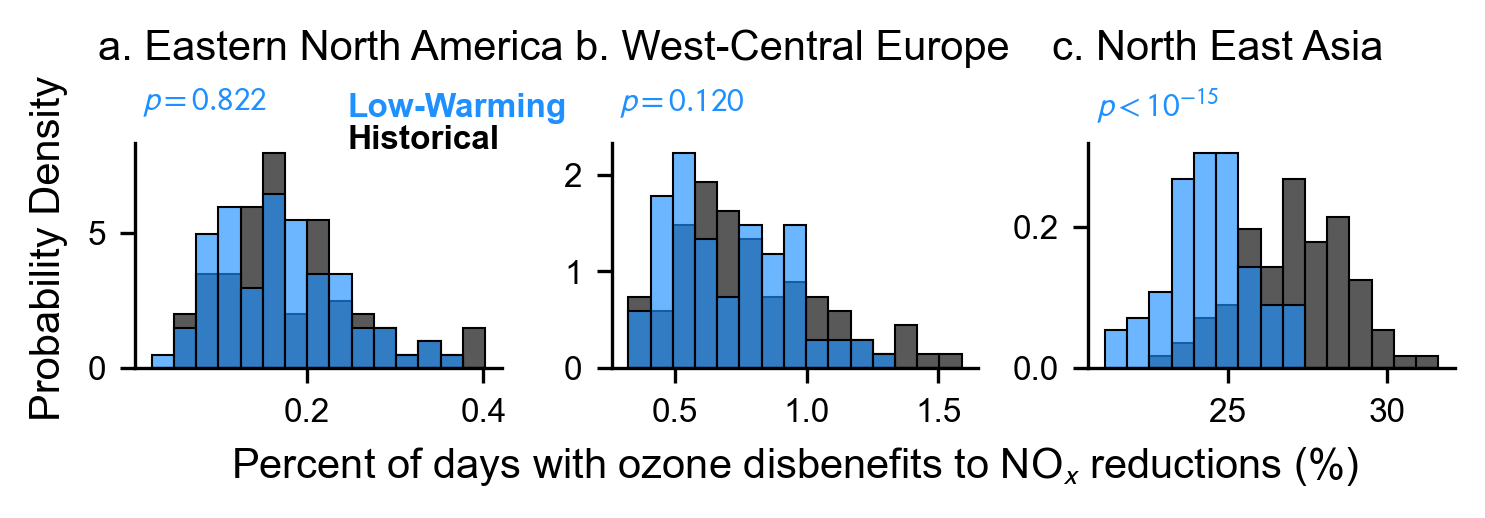

In [10]:
tools.set_matplotlib_font("Arial")

mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})

fig = plt.figure(figsize=(5.0, 1.6), dpi=300)
gs1 = GridSpec(1, 3, top=0.72, bottom=0.25, left=0.09, right=0.97, hspace=0.50, wspace=0.3)
ax4 = fig.add_subplot(gs1[0, 0])
ax5 = fig.add_subplot(gs1[0, 1])
ax6 = fig.add_subplot(gs1[0, 2])

###############################################
# Part 2: O3 disbenefit days per season - LOW WARMING vs HISTORICAL

axes = [ax4, ax5, ax6]
titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. North East Asia",
]
datasets = [
    (ENA_present, ENA_futurepol, "dodgerblue"), 
    (WCE_present, WCE_futurepol, "dodgerblue"), 
    (EAS_present, EAS_futurepol, "dodgerblue"), 
]

num_bins = 15
for i, (data1, data2, color2) in enumerate(datasets):
    plot_histogram(axes[i], data1, data2, num_bins, titles[i], color2)
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_ylabel(None)
    axes[i].tick_params(axis='both', labelsize=8)

# Legend
ax4.text(0.58, 1.22, "Low-Warming", ha='left', va='top', transform=ax4.transAxes, color='dodgerblue', fontsize=8, fontweight='bold')
ax4.text(0.58, 1.08, "Historical", ha='left', va='top', transform=ax4.transAxes, color='black', fontsize=8, fontweight='bold')

# X-label
axes[1].set_xlabel("Percent of days with ozone disbenefits to NO$_x$ reductions (%)", fontsize=10)

# Y-label
fig.supylabel(ylabel)

###############################################

plt.savefig("FigS4_new.png")

In [11]:
# Calculate mean and standard deviation of NEA disbenefit days (reported in Section 3.4)
print("Historical percent of O3 disbenefit days in NEA:")
print(np.mean(EAS_present))
print(np.std(EAS_present))

print("High-warming percent of O3 disbenefit days in NEA:")
print(np.mean(EAS_future))
print(np.std(EAS_future))

print("Low-warming percent of O3 disbenefit days in NEA:")
print(np.mean(EAS_futurepol))
print(np.std(EAS_futurepol))

print("Change")
print(np.mean(EAS_future-EAS_present))
print(np.mean((EAS_future-EAS_present)/EAS_present * 100))


Historical percent of O3 disbenefit days in NEA:
27.1031746031746
1.7094780196853046
High-warming percent of O3 disbenefit days in NEA:
23.70236636321195
1.6633616308079335
Low-warming percent of O3 disbenefit days in NEA:
24.42124766573296
1.310875527529255
Change
-3.4008082399626516
-12.127950184325957
